# M5 Forecasting Challenge: EDA
#### Author: Stacy Liu

## Introduction

**The goal**: We have been challenged to **predict sales data** provided by the retail giant Walmart 28 days into the future. This competition will run in 2 tracks: In addition to forecasting the values themselves in the Forecasting competition, we are simultaneously tasked to **estimate the uncertainty** of our predictions in the Uncertainty Distribution competition. Both competitions will have the same 28 day forecast horizon.

**The goal of EDA Notebook**: This notebook will be used to visualize the sales data and gain some insights from it.

**The data**: We are working with **42,840 hierarchical time series**. The data were obtained in the 3 US states of California (CA), Texas (TX), and Wisconsin (WI). “Hierarchical” here means that data can be aggregated on different levels: item level, department level, product category level, and state level. The sales information reaches back from Jan 2011 to June 2016. In addition to the sales numbers, we are also given corresponding data on prices, promotions, and holidays. Note, that we have been warned that **most of the time series contain zero values.**

The data comprises **3049** individual products from *3 categories* and *7 departments*, sold in 10 stores in 3 states. The hierachical aggregation captures the combinations of these factors. For instance, we can create 1 time series for all sales, 3 time series for all sales per state, and so on. The largest category is sales of all individual 3049 products per 10 stores for 30490 time series.

The training data comes in the shape of 3 separate files:

- sales_train.csv: this is our main training data.  Contains the historical daily unit sales data per product and store from d_1 - d_1913.

- sell_prices.csv: the store and item IDs together with the sales price of the item as a weekly average.

- calendar.csv: dates together with related features like day-of-the week, month, year, and an 3 binary flags for whether the stores in each state allowed purchases with SNAP food stamps at this date (1) or not (0).

- sales_train_evaluation.csv - Available one month before the competition deadline. It will include sales from d_1 - d_1941.

**The metrics:**

The point forecast submission are being evaluated using the **Root Mean Squared Scaled Error (RMSSE)**, which is derived from the Mean Absolute Scaled Error (MASE) that was designed to be scale invariant and symmetric. 

# EDA Summary
- The rolling 90 day sales by state shows that sales for all three States have been increasing from 2011 to 2016
	- CA sold the most amount of items during the entire 5 year period
		- CA has four stores with store 3 always having highest sales
		- CA_1 and CA_4 had comparably flatter growth
		- CA_3 had a long decline, followed by steep increase at around day 1550 --> **for CA_3 might want to try removing d1510-1750**
	- WI overtook TX in terms of the number of the items sold around day 1600
		- Around day 1000, all three TX stores had a steep decline in sales, especially so for store TX_2 --> **for TX might want to try limiting training dataset to d1100 and after**
		- WI_1 and WI_2 saw steep growth in sales after slower beginnng
		- WI_3 sale started declining when WI_1 and WI_2 began growing --> **WI had lots of movement during the first 750 days. Might want to limit data to after d750
	- There's some seasonality at play here with sales reaching a local max every 300-400 days
- By Category:
	- Food has the highest unit sales during this period, followed by household items, and lastly hobbies. In particular FOODS_3 has much higher sales than any other department.
		- Food appears to be driving high avg sales on event days, in particular for Easter, Father's Day, Labor Day, Mother's Day, Orthodox Easter, and Superbowl
	- Household: Where we are seeing peaks in Food sale, we are also seeing bump in household item sales (especially for Easter, Labor Day, Orthodox Easter, and Superbowl)
	- Hobbies does not have much variation between events except for dips on Independence Day, New Year, and Thanksgiving
- By Calendar:
	- Walmart sales has been increasing from 2012 to 2016. The one day every year where we see close to zero sales is Christmas when stores are closed. --> **remove Christmas from the training dataset**
	- Easter, Father's Day, LaborDay, MemorialDay, OthodoxEaster, and St Patricks Day appears to have much higher sales than no event days.
	- For Event_Name_2, Cinco de Mayo, Father's Day, and OthodoxEaster appears to have much higher sales than no event days.
	- Average daily sale is much higher 1-2 days prior to events than the actual event, driven by Food. --> **create a customized calendar to flag 2 days prior events**
	- In all 3 States, SNAP days generated larger sales
	- Seasonality:
		- Sales were the highest on the weekend (fri-sun).
		- Sales are higher in the first half of the month --> may be result of SNAP
		- Sales peaked in the summer months (June-Oct).
- By Price:
	- Price does not seem to have an effect on sales amt
- At the item level sales are sporatic with lots of days with zero sales

## Initial Data Loading

#### Import Libraries

In [1]:
# Import libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pickle
import os

%matplotlib inline

Run the below code to reduce memory usage when importing cvs

In [2]:
def reduce_mem_usage(df, verbose=True):
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if   c_min > np.iinfo(np.int8 ).min and c_max < np.iinfo(np.int8).max :
                    df[col] = df[col].astype(np.int8 )
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if   c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
        
    return df

In [3]:
# Load data
#filename = os.path.join("Data", "m5-forecasting-accuracy-updated", "sales_train_validation.csv")
#sales_train = reduce_mem_usage(pd.read_csv(filename))
#sales_train.head()

In [4]:
# Load data
filename = os.path.join("Data", "m5-forecasting-accuracy-updated", "sales_train_evaluation.csv")
sales_eva = reduce_mem_usage(pd.read_csv(filename))
sales_eva.head()

Mem. usage decreased to 96.13 Mb (78.8% reduction)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [5]:
print(sales_eva.shape)
print(sales_eva.dtypes)

(30490, 1947)
id          object
item_id     object
dept_id     object
cat_id      object
store_id    object
             ...  
d_1937        int8
d_1938        int8
d_1939        int8
d_1940       int16
d_1941        int8
Length: 1947, dtype: object


In [6]:
# Correct data types for "calendar.csv"
calendarDTypes = {"event_name_1": "category", 
                  "event_name_2": "category", 
                  "event_type_1": "category", 
                  "event_type_2": "category", 
                  "weekday": "category", 
                  'wm_yr_wk': 'int16', 
                  "wday": "int16",
                  "month": "int16", 
                  "year": "int16", 
                  "snap_CA": "float32", 
                  'snap_TX': 'float32', 
                  'snap_WI': 'float32' }

# Load data
filename = os.path.join("Data", "m5-forecasting-accuracy-updated", "calendar.csv")
calendar = reduce_mem_usage(pd.read_csv(filename, dtype = calendarDTypes))
calendar['date']=pd.to_datetime(calendar['date'])
calendar.head()

Mem. usage decreased to  0.06 Mb (18.9% reduction)


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1.0,1.0,0.0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1.0,0.0,1.0


In [7]:
# Event Calendar
event_calendar = calendar.loc[calendar['event_name_1'].notnull(),['date','event_name_1']]
event_calendar['1_day_prior']=event_calendar['date']-dt.timedelta(days=1)
event_calendar['1_day_after']=event_calendar['date']+dt.timedelta(days=1)
event_calendar['2_days_prior']=event_calendar['date']-dt.timedelta(days=2)
event_calendar['2_days_after']=event_calendar['date']+dt.timedelta(days=2)
event_calendar['3_days_prior']=event_calendar['date']-dt.timedelta(days=3)
event_calendar['3_days_after']=event_calendar['date']+dt.timedelta(days=3)

# add column for days before and after events. Hypothesis that sales goes up before an event.
for i in range(len(calendar)):
    day = calendar.loc[[i],'date'].values[0]
    day = pd.to_datetime(day)
    if day in set(event_calendar['date']):
        calendar.loc[[i],'prior_after'] = 'event'
    elif day in set(event_calendar['1_day_prior']):
        calendar.loc[[i],'prior_after'] = '1_day_prior'
    elif day in set(event_calendar['2_days_prior']):
        calendar.loc[[i],'prior_after'] = '2_days_prior' 
    elif day in set(event_calendar['3_days_prior']):
        calendar.loc[[i],'prior_after'] = '3_days_prior' 
    elif day in set(event_calendar['1_day_after']):
        calendar.loc[[i],'prior_after'] = '1_day_after'
    elif day in set(event_calendar['2_days_after']):
        calendar.loc[[i],'prior_after'] = '2_days_after' 
    elif day in set(event_calendar['3_days_after']):
        calendar.loc[[i],'prior_after'] = '3_days_after'
    else:
        calendar.loc[[i],'prior_after'] = 'NaN'

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,prior_after
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1.0,0.0,1.0,NaN
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1.0,1.0,1.0,3_days_prior
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1.0,0.0,0.0,2_days_prior
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1_day_prior
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1.0,1.0,1.0,event
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1_day_after


In [52]:
# add in week, quarter, day of the month
dateFeatures = {"wday": "weekday",
                "week": "weekofyear",
                "month": "month",
                "quarter": "quarter",
                "year": "year",
                "mday": "day"}

for featName, featFunc in dateFeatures.items():
    if featName in calendar.columns:
        calendar[featName] = calendar[featName].astype("int16")
    else:
        calendar[featName] = getattr(calendar["date"].dt, featFunc).astype("int16")

calendar.head(20)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,prior_after,week,quarter,mday
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,4,1,29
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,4,1,30
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,5,1,31
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,5,1,1
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1.0,0.0,1.0,NaN,5,1,2
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1.0,1.0,1.0,3_days_prior,5,1,3
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1.0,0.0,0.0,2_days_prior,5,1,4
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1_day_prior,5,1,5
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1.0,1.0,1.0,event,5,1,6
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1_day_after,6,1,7


In [8]:
# Correct data types for "sell_prices.csv"
priceDTypes = {"store_id": "category", 
               "item_id": "category", 
               "wm_yr_wk": "int16",
               "sell_price":"float32"}

#sub_filename = r"Data\m5-forecasting-accuracy-updated\sell_prices.csv"
sub_filename = os.path.join("Data", "m5-forecasting-accuracy-updated", "sell_prices.csv")
prices = reduce_mem_usage(pd.read_csv(sub_filename, dtype = priceDTypes))
     
prices.head()

Mem. usage decreased to 45.77 Mb (22.2% reduction)


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


In [9]:
sub_filename = os.path.join("Data", "m5-forecasting-accuracy-updated", "sample_submission.csv")
submission = reduce_mem_usage(pd.read_csv(sub_filename))

Mem. usage decreased to  2.09 Mb (84.5% reduction)


# Exploratory Data Analysis

## Sales Data EDA

**Visualizing sales for a single item**

<function matplotlib.pyplot.show(*args, **kw)>

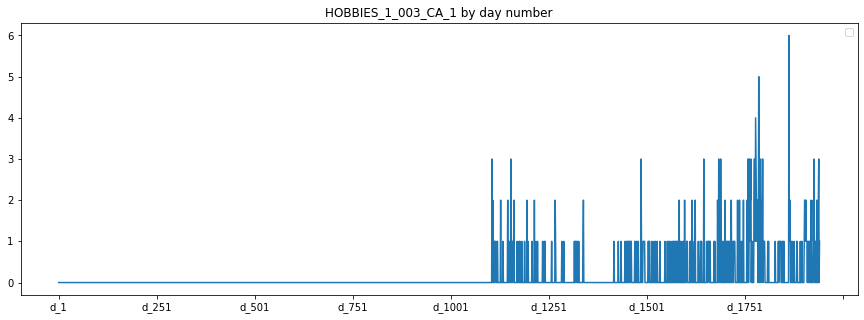

In [10]:
d_cols=[c for c in sales_eva.columns if 'd_' in c]

#select the item
sales_eva.loc[sales_eva['id'] == 'HOBBIES_1_003_CA_1_evaluation'] \
.set_index('id')[d_cols] \
.T \
.plot(figsize=(15,5),
      title='HOBBIES_1_003_CA_1 by day number')
plt.legend('')
plt.show

HOBBIES_1_003_CA_1 did not have any sales till d_1100. After which sales is still sporatic with lots of 0s.

**Rolling Total Sales**

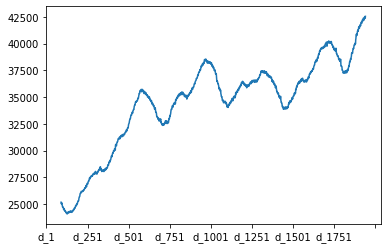

In [11]:
total_sales=sales_eva.sum(axis=0, skipna = True, numeric_only = True)
total_sales.head(20)
total_sales.T.rolling(90).mean().plot()

**Rolling Sales by State**

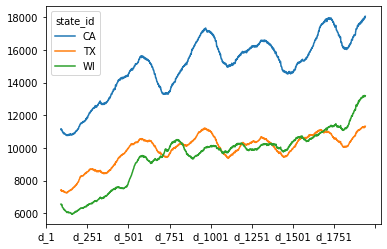

In [12]:
state_sales=sales_eva.groupby('state_id').agg('sum')
state_sales.T.rolling(90).mean().plot()

A rolling 90 day sales by state shows that sales for all three States have been **increasing** from 2011 to 2016

- CA sold the most amount of items during the entire 5 year period
- WI overtook TX in terms of the number of the items sold around day 1600
- There's some seasonality at play here with sales reaching a local max every 300-400 days

**Rolling Sales by Store ID**

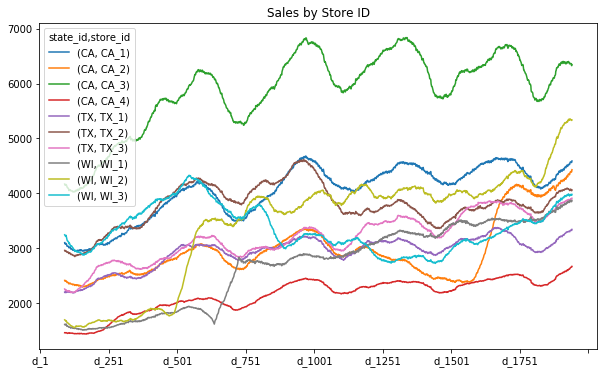

In [13]:
store_id_sales=sales_eva.groupby(['state_id','store_id']).agg('sum')
ax = plt.figure(figsize=(10, 6)).gca()
store_id_sales.T.rolling(90).mean().plot(ax=ax)
plt.title('Sales by Store ID')
plt.show()

**California**

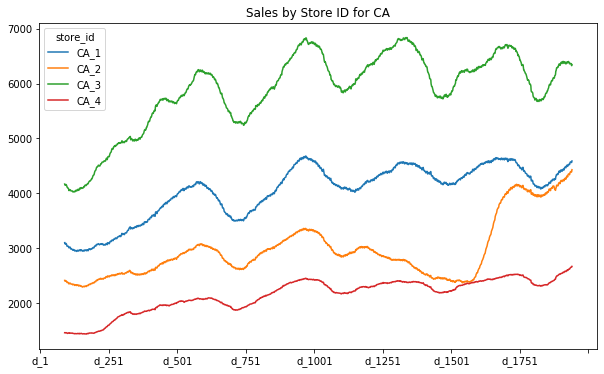

In [49]:
ca_sales=sales_eva.loc[sales_eva['state_id']=='CA']
ca_sales_by_store=ca_sales.groupby('store_id').agg('sum')
ax = plt.figure(figsize=(10, 6)).gca()
ca_sales_by_store.T.rolling(90).mean().plot(ax=ax)
plt.title('Sales by Store ID for CA')
plt.show()

- CA has four stores with store 3 always having highest sales
- CA_1 and CA_4 had comparably flatter growth
- CA_3 had a long decline, followed by steep increase at around day 1550

**Texas**

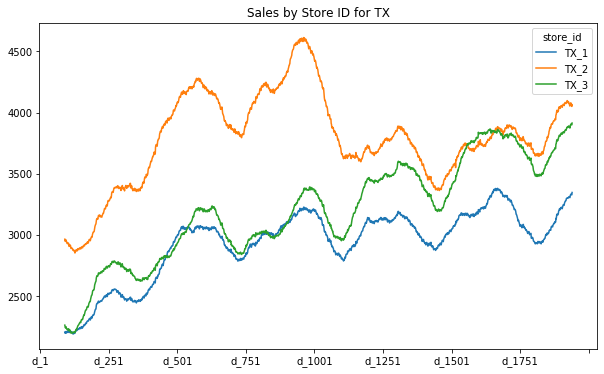

In [17]:
tx_sales=sales_eva.loc[sales_eva['state_id']=='TX']
tx_sales_by_store=tx_sales.groupby('store_id').agg('sum')
ax = plt.figure(figsize=(10, 6)).gca()
tx_sales_by_store.T.rolling(90).mean().plot(ax=ax)
plt.title('Sales by Store ID for TX')
plt.show()

- Around day 1000, all three TX stores had a steep decline in sales, especially so for store TX_2

**Wisconsin**

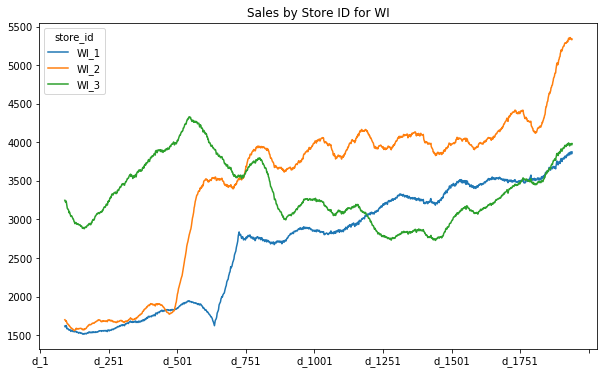

In [18]:
wi_sales=sales_eva.loc[sales_eva['state_id']=='WI']
wi_sales_by_store=wi_sales.groupby('store_id').agg('sum')
ax = plt.figure(figsize=(10, 6)).gca()
wi_sales_by_store.T.rolling(90).mean().plot(ax=ax)
plt.title('Sales by Store ID for WI')
plt.show()

- WI_1 and WI_2 saw steep growth in sales after slower beginnng
- WI_3 sale started declining when WI_1 and WI_2 began growing

**Rolling Sales by Category**

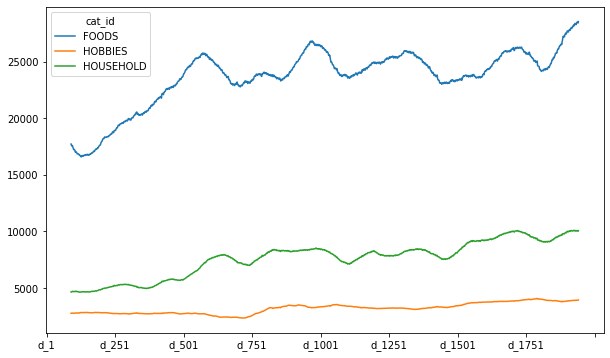

In [19]:
cat_sales=sales_eva.groupby(['cat_id']).agg('sum')
ax = plt.figure(figsize=(10, 6)).gca()
cat_sales.T.rolling(90).mean().plot(ax=ax)

Food has the highest unit sales during this period, followed by household items, and lastly hobbies

**Rolling Sales by Dept**

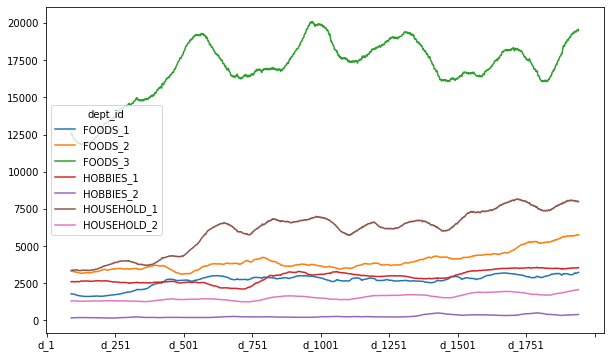

In [20]:
agg_dept_sales=sales_eva.groupby(['dept_id']).agg('sum')
ax = plt.figure(figsize=(10, 6)).gca()
agg_dept_sales.T.rolling(90).mean().plot(ax=ax)

In particular FOODS_3 has much higher sales than any other department

## Calendar Data EDA

In [53]:
# Transpose sales_eva  
sales_eva_transposed = pd.melt(sales_eva,
             id_vars = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id'],
             value_vars = [col for col in sales_eva.columns if col.startswith("d_")],
             var_name = "d",
             value_name = "sales")

sales_eva_transposed.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,CA_1,HOBBIES,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,CA_1,HOBBIES,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,CA_1,HOBBIES,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,CA_1,HOBBIES,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,CA_1,HOBBIES,CA,d_1,0


In [54]:
# merge with calendar
sales_eva_calendar = sales_eva_transposed.merge(calendar, on = "d", copy = False)
sales_eva_calendar.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,...,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,prior_after,week,quarter,mday
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,CA_1,HOBBIES,CA,d_1,0,2011-01-29,11101,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,4,1,29
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,CA_1,HOBBIES,CA,d_1,0,2011-01-29,11101,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,4,1,29
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,CA_1,HOBBIES,CA,d_1,0,2011-01-29,11101,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,4,1,29
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,CA_1,HOBBIES,CA,d_1,0,2011-01-29,11101,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,4,1,29
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,CA_1,HOBBIES,CA,d_1,0,2011-01-29,11101,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,4,1,29


**Sales over time**

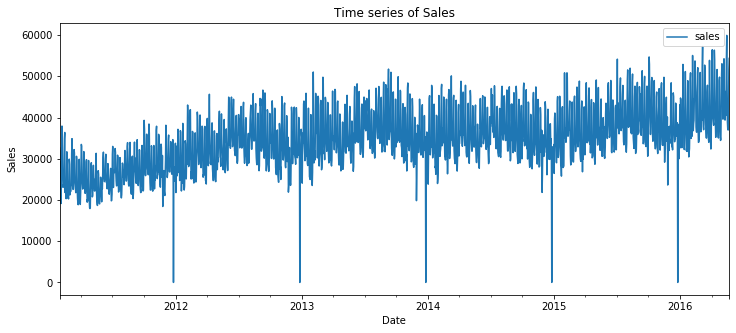

In [23]:
sales_merged_all=sales_eva_calendar.groupby(['date'], as_index=False)['sales'].sum()
ax = plt.figure(figsize=(12, 5)).gca()
sales_merged_all.plot(x='date',y='sales', ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Time series of Sales')
plt.show()

Walmart sales has been increasing from 2012 to 2016. The one day every year where we see close to zero sales is Christmas when stores are closed.

In [24]:
zero_sales = sales_merged_all.loc[sales_merged_all['sales'] < 100]
zero_sales.head()

,date,sales
330,2011-12-25,13.0
696,2012-12-25,11.0
1061,2013-12-25,20.0
1426,2014-12-25,20.0
1791,2015-12-25,14.0


**Avg Daily Sales by Event**

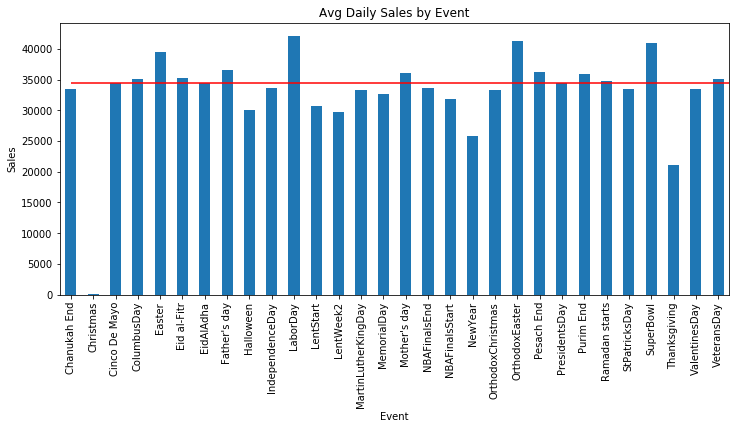

In [25]:
sales_merged_event=sales_eva_calendar.groupby(['event_name_1', 'date'], as_index=False)['sales'].sum().groupby('event_name_1')['sales'].mean()
avg_daily_sales = sales_eva_calendar.groupby(['date'], as_index=False)['sales'].sum().mean()
ax = plt.figure(figsize=(12, 5)).gca()
sales_merged_event.plot.bar(x='event_name_1',y='sales', ax=ax)
plt.hlines(avg_daily_sales, xmin=0, xmax=30,color='r', linestyle='-')
ax.set_xlabel('Event')
ax.set_ylabel('Sales')
ax.set_title('Avg Daily Sales by Event')
plt.show()

Easter, Father's Day, LaborDay, MemorialDay, OthodoxEaster, and St Patricks Day appears to have much higher sales than no event days. 

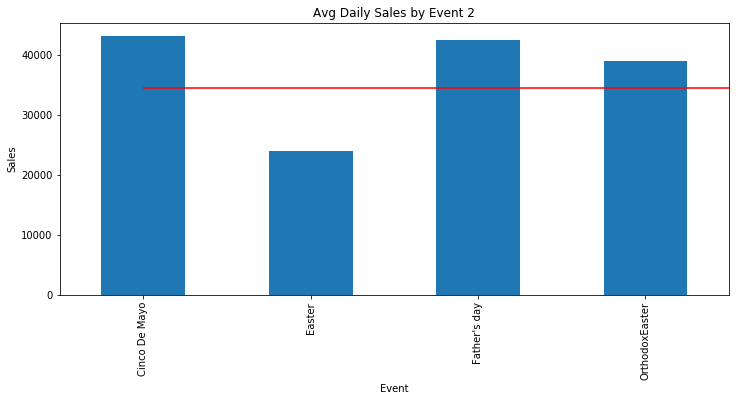

In [26]:
#event name 2
sales_merged_event=sales_eva_calendar.groupby(['event_name_2', 'date'], as_index=False)['sales'].sum().groupby('event_name_2')['sales'].mean()
avg_daily_sales = sales_eva_calendar.groupby(['date'], as_index=False)['sales'].sum().mean()
ax = plt.figure(figsize=(12, 5)).gca()
sales_merged_event.plot.bar(x='event_name_2',y='sales', ax=ax)
plt.hlines(avg_daily_sales, xmin=0, xmax=30,color='r', linestyle='-')
ax.set_xlabel('Event')
ax.set_ylabel('Sales')
ax.set_title('Avg Daily Sales by Event 2')
plt.show()

For Event_Name_2, Cinco de Mayo, Father's Day, and OthodoxEaster appears to have much higher sales than no event days.

**Avg Daily Sales by Event & Category**

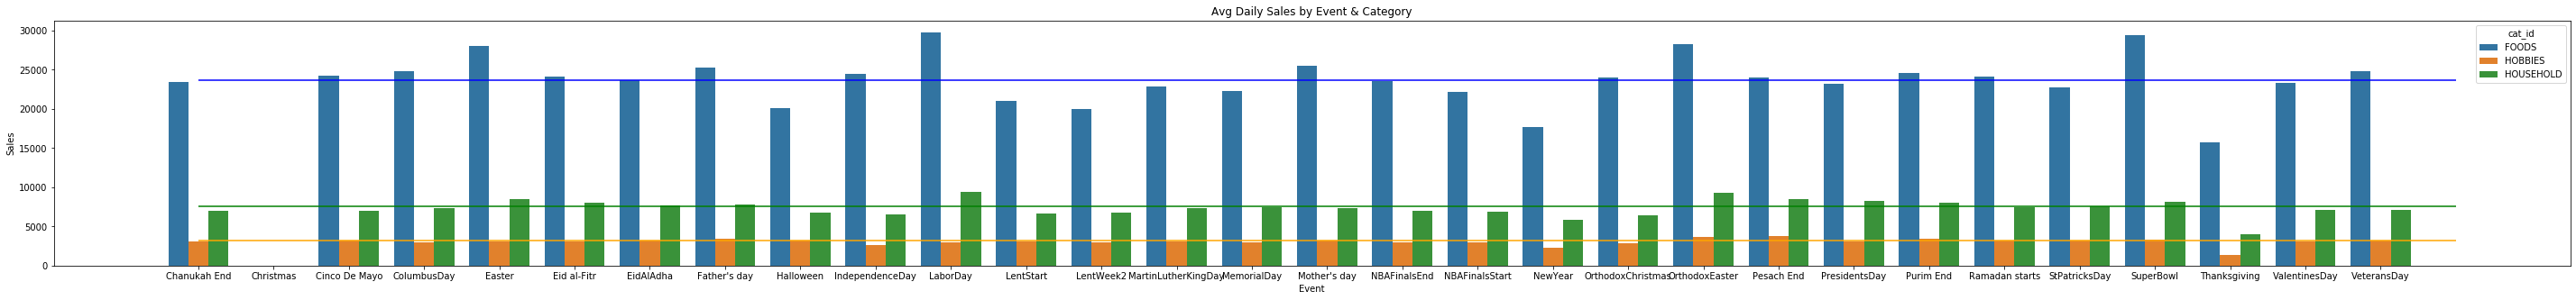

In [27]:
sales_merged_event_cat=sales_eva_calendar.groupby(['event_name_1', 'cat_id', 'date'], as_index=False)['sales'].sum().groupby(['event_name_1', 'cat_id'], as_index=False)['sales'].mean()
avg_daily_sales_food = sales_eva_calendar.loc[sales_eva_calendar['cat_id']=='FOODS'].groupby(['date'], as_index=False)['sales'].sum().mean()
avg_daily_sales_hobbies = sales_eva_calendar.loc[sales_eva_calendar['cat_id']=='HOBBIES'].groupby(['date'], as_index=False)['sales'].sum().mean()
avg_daily_sales_household = sales_eva_calendar.loc[sales_eva_calendar['cat_id']=='HOUSEHOLD'].groupby(['date'], as_index=False)['sales'].sum().mean()
ax = plt.figure(figsize=(50, 5)).gca()
sns.barplot(x='event_name_1',y='sales', hue='cat_id', ax=ax, data=sales_merged_event_cat)
plt.hlines(avg_daily_sales_food, xmin=0, xmax=30,color='b', linestyle='-')
plt.hlines(avg_daily_sales_hobbies, xmin=0, xmax=30,color='orange', linestyle='-')
plt.hlines(avg_daily_sales_household, xmin=0, xmax=30,color='g', linestyle='-')
ax.set_xlabel('Event')
ax.set_ylabel('Sales')
ax.set_title('Avg Daily Sales by Event & Category')
plt.show()

- Food appears to be driving high avg sales on event days, in particular for Easter, Father's Day, Labor Day, Mother's Day, Orthodox Easter, and Superbowl
- Where we are seeing peaks in Food sale, we are also seeing bump in household item sales (especially for Easter, Labor Day, Orthodox Easter, and Superbowl)
- Hobbies does not have much variation between events except for dips on Independence Day, New Year, and Thanksgiving

**Avg Daily Sales prior and after events**

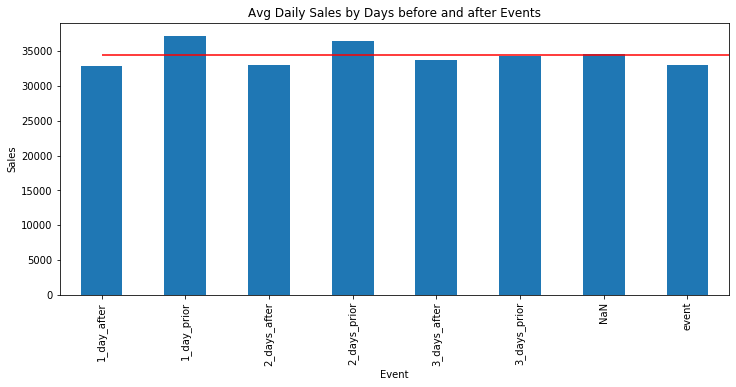

In [28]:
sales_merged_prior_after_events=sales_eva_calendar.groupby(['prior_after', 'date'], as_index=False)['sales'].sum().groupby('prior_after')['sales'].mean()
avg_daily_sales = sales_eva_calendar.groupby(['date'], as_index=False)['sales'].sum().mean()
ax = plt.figure(figsize=(12, 5)).gca()
sales_merged_prior_after_events.plot.bar(x='prior_after',y='sales', ax=ax)
plt.hlines(avg_daily_sales, xmin=0, xmax=30,color='r', linestyle='-')
ax.set_xlabel('Event')
ax.set_ylabel('Sales')
ax.set_title('Avg Daily Sales by Days before and after Events')
plt.show()

Average daily sale is much higher 1-2 days prior to events than the actual event.

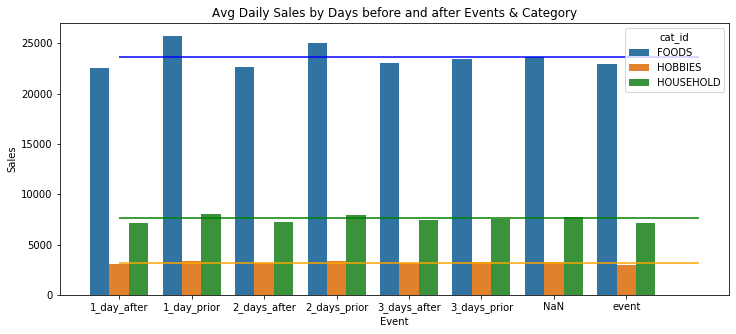

In [34]:
sales_merged_prior_after_event_cat=sales_eva_calendar.groupby(['prior_after', 'cat_id', 'date'], as_index=False)['sales'].sum().groupby(['prior_after', 'cat_id'], as_index=False)['sales'].mean()
avg_daily_sales_food = sales_eva_calendar.loc[sales_eva_calendar['cat_id']=='FOODS'].groupby(['date'], as_index=False)['sales'].sum().mean()
avg_daily_sales_hobbies = sales_eva_calendar.loc[sales_eva_calendar['cat_id']=='HOBBIES'].groupby(['date'], as_index=False)['sales'].sum().mean()
avg_daily_sales_household = sales_eva_calendar.loc[sales_eva_calendar['cat_id']=='HOUSEHOLD'].groupby(['date'], as_index=False)['sales'].sum().mean()
ax = plt.figure(figsize=(12, 5)).gca()
sns.barplot(x='prior_after',y='sales', hue='cat_id', ax=ax, data=sales_merged_prior_after_event_cat)
plt.hlines(avg_daily_sales_food, xmin=0, xmax=8,color='b', linestyle='-')
plt.hlines(avg_daily_sales_hobbies, xmin=0, xmax=8,color='orange', linestyle='-')
plt.hlines(avg_daily_sales_household, xmin=0, xmax=8,color='g', linestyle='-')
ax.set_xlabel('Event')
ax.set_ylabel('Sales')
ax.set_title('Avg Daily Sales by Days before and after Events & Category')
plt.show()

Again, this increase is driven by food.

**Avg Daily Sales by Food Stamp Flag**

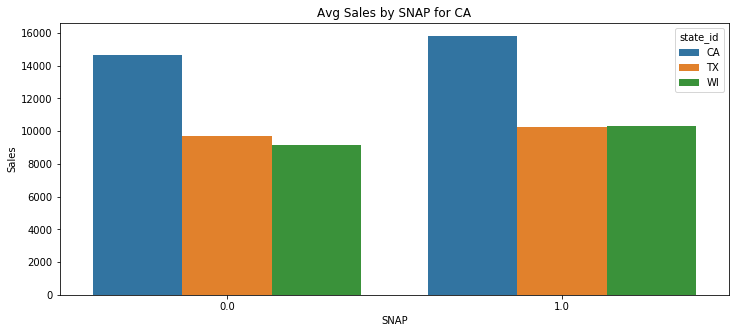

In [35]:
sales_merged_cafoodstamp=sales_eva_calendar.groupby(['state_id', 'snap_CA', 'date'], as_index=False)['sales'].sum().groupby(['state_id', 'snap_CA'], as_index=False)['sales'].mean()
ax = plt.figure(figsize=(12, 5)).gca()
sns.barplot(x='snap_CA',y='sales', hue='state_id', ax=ax, data=sales_merged_cafoodstamp)
ax.set_xlabel('SNAP')
ax.set_ylabel('Sales')
ax.set_title('Avg Sales by SNAP for CA')
plt.show()

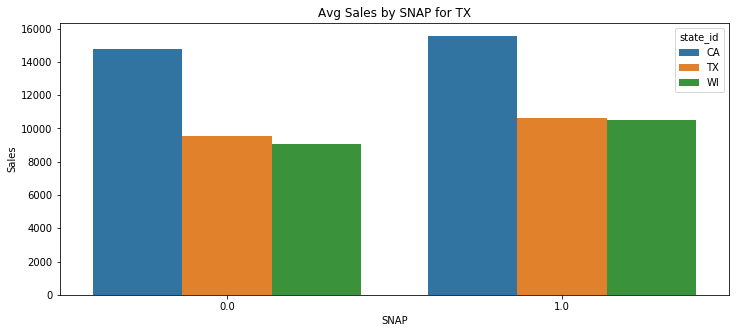

In [36]:
sales_merged_txfoodstamp=sales_eva_calendar.groupby(['state_id', 'snap_TX', 'date'], as_index=False)['sales'].sum().groupby(['state_id', 'snap_TX'], as_index=False)['sales'].mean()
ax = plt.figure(figsize=(12, 5)).gca()
sns.barplot(x='snap_TX',y='sales', hue='state_id', ax=ax, data=sales_merged_txfoodstamp)
ax.set_xlabel('SNAP')
ax.set_ylabel('Sales')
ax.set_title('Avg Sales by SNAP for TX')
plt.show()

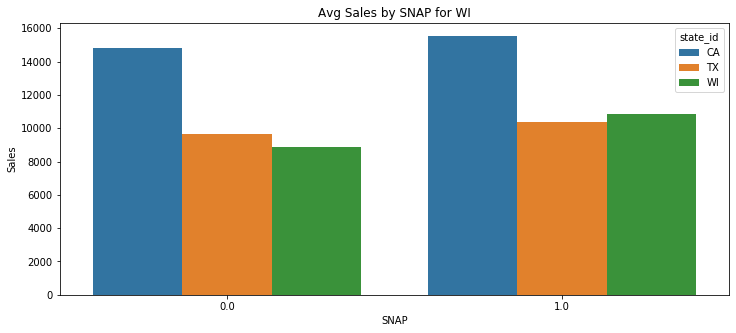

In [37]:
sales_merged_wifoodstamp=sales_eva_calendar.groupby(['state_id', 'snap_WI', 'date'], as_index=False)['sales'].sum().groupby(['state_id', 'snap_WI'], as_index=False)['sales'].mean()
ax = plt.figure(figsize=(12, 5)).gca()
sns.barplot(x='snap_WI',y='sales', hue='state_id', ax=ax, data=sales_merged_wifoodstamp)
ax.set_xlabel('SNAP')
ax.set_ylabel('Sales')
ax.set_title('Avg Sales by SNAP for WI')
plt.show()

In all 3 States, SNAP days generated larger sales

**Daily Sales by day of the week**

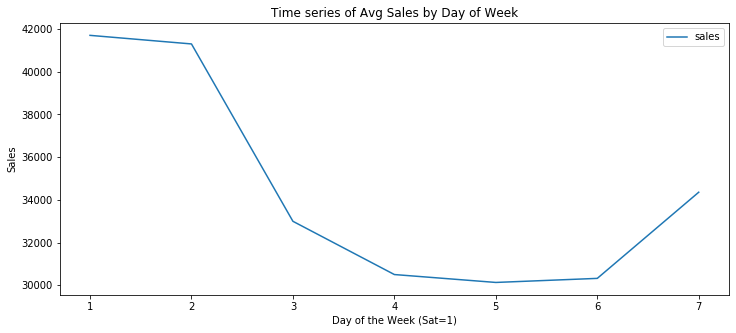

In [39]:
sales_merged_all_dayofweek=sales_eva_calendar.groupby(['wday', 'date'], as_index=False).sum().groupby(['wday'], as_index=False)['sales'].mean()
ax = plt.figure(figsize=(12, 5)).gca()
sales_merged_all_dayofweek.plot(x='wday',y='sales', ax=ax)
ax.set_xlabel('Day of the Week (Sat=1)')
ax.set_ylabel('Sales')
ax.set_title('Time series of Avg Sales by Day of Week')
plt.show()

Sales were the highest on the weekend (fri-sun).

**Daily Sales by day of the month**

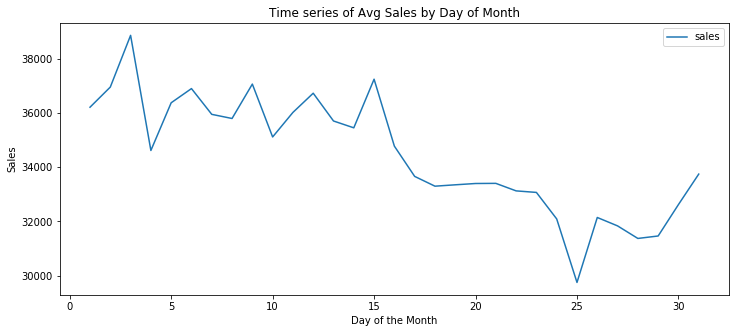

In [55]:
sales_merged_all_dayofmonth=sales_eva_calendar.groupby(['mday', 'date'], as_index=False).sum().groupby(['mday'], as_index=False)['sales'].mean()
ax = plt.figure(figsize=(12, 5)).gca()
sales_merged_all_dayofmonth.plot(x='mday',y='sales', ax=ax)
ax.set_xlabel('Day of the Month')
ax.set_ylabel('Sales')
ax.set_title('Time series of Avg Sales by Day of Month')
plt.show()

Sales are higher in the first half of the month --> may be result of SNAP

**Daily Sales by Month**

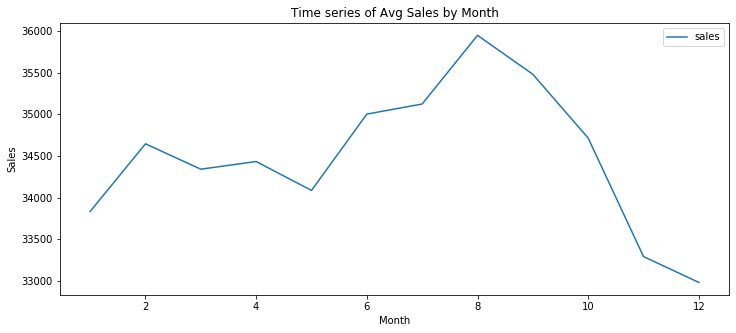

In [40]:
sales_merged_all_dayofweek=sales_eva_calendar.groupby(['month', 'date'], as_index=False).sum().groupby(['month'], as_index=False)['sales'].mean()
ax = plt.figure(figsize=(12, 5)).gca()
sales_merged_all_dayofweek.plot(x='month',y='sales', ax=ax)
ax.set_xlabel('Month')
ax.set_ylabel('Sales')
ax.set_title('Time series of Avg Sales by Month')
plt.show()

Sales peaked in the summer months (June-Oct).

## Sales Price EDA

In [41]:
# merge with sales price
sales = sales_eva_calendar.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], how = 'left')
sales.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,prior_after,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,CA_1,HOBBIES,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,CA_1,HOBBIES,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,CA_1,HOBBIES,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,CA_1,HOBBIES,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,CA_1,HOBBIES,CA,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN


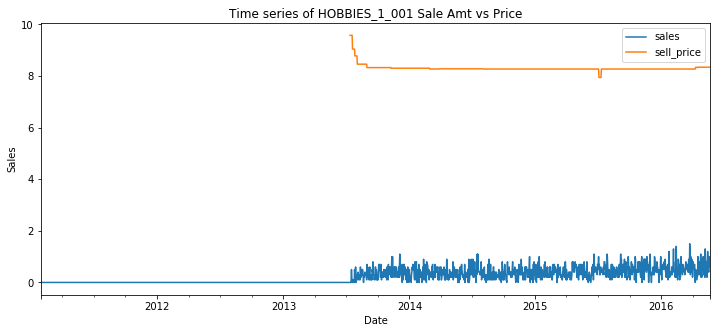

In [46]:
# Plot sales amt vs. avg sale price for one item
sales_HOBBIES_1_001 = sales[sales['item_id']=='HOBBIES_1_001']

hobbies_1_001_sales_amt=sales_HOBBIES_1_001.groupby(['date'], as_index=False)['sales'].mean()
hobbies_1_001_sales_price=sales_HOBBIES_1_001.groupby(['date'], as_index=False)['sell_price'].mean()
ax = plt.figure(figsize=(12, 5)).gca()
hobbies_1_001_sales_amt.plot(x='date',y='sales', ax=ax)
hobbies_1_001_sales_price.plot(x='date',y='sell_price', ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Time series of HOBBIES_1_001 Sale Amt vs Price')
plt.show()

In [48]:
sales_HOBBIES_1_001[['sales', 'sell_price']].corr()

,sales,sell_price
sales,1.000000,-0.066819
sell_price,-0.066819,1.000000


Price has been consistent and does not seem to affect sale amount.

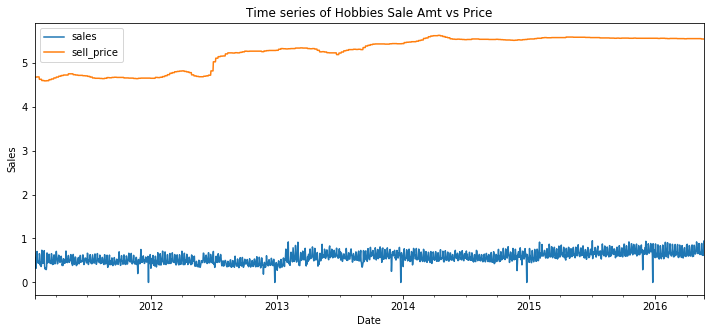

In [45]:
# let's check for a category
sales_hobbies = sales[sales['cat_id']=='HOBBIES']

hobbies_sales_amt=sales_hobbies.groupby(['date'], as_index=False)['sales'].mean()
hobbies_sales_price=sales_hobbies.groupby(['date'], as_index=False)['sell_price'].mean()
ax = plt.figure(figsize=(12, 5)).gca()
hobbies_sales_amt.plot(x='date',y='sales', ax=ax)
hobbies_sales_price.plot(x='date',y='sell_price', ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Time series of Hobbies Sale Amt vs Price')
plt.show()

In [47]:
sales_hobbies[['sales', 'sell_price']].corr()

,sales,sell_price
sales,1.000000,-0.104009
sell_price,-0.104009,1.000000


Same as HOBBIES_1_001, sales price does not seem to have an effect on sales amt of hobbies.

# EDA Summary

- The rolling 90 day sales by state shows that sales for all three States have been increasing from 2011 to 2016
	- CA sold the most amount of items during the entire 5 year period
		- CA has four stores with store 3 always having highest sales
		- CA_1 and CA_4 had comparably flatter growth
		- CA_3 had a long decline, followed by steep increase at around day 1550 --> **for CA_3 might want to try removing d1510-1750**
	- WI overtook TX in terms of the number of the items sold around day 1600
		- Around day 1000, all three TX stores had a steep decline in sales, especially so for store TX_2 --> **for TX might want to try limiting training dataset to d1100 and after**
		- WI_1 and WI_2 saw steep growth in sales after slower beginnng
		- WI_3 sale started declining when WI_1 and WI_2 began growing --> **WI had lots of movement during the first 750 days. Might want to limit data to after d750
	- There's some seasonality at play here with sales reaching a local max every 300-400 days
- By Category:
	- Food has the highest unit sales during this period, followed by household items, and lastly hobbies. In particular FOODS_3 has much higher sales than any other department.
		- Food appears to be driving high avg sales on event days, in particular for Easter, Father's Day, Labor Day, Mother's Day, Orthodox Easter, and Superbowl
	- Household: Where we are seeing peaks in Food sale, we are also seeing bump in household item sales (especially for Easter, Labor Day, Orthodox Easter, and Superbowl)
	- Hobbies does not have much variation between events except for dips on Independence Day, New Year, and Thanksgiving
- By Calendar:
	- Walmart sales has been increasing from 2012 to 2016. The one day every year where we see close to zero sales is Christmas when stores are closed. --> **remove Christmas from the training dataset**
	- Easter, Father's Day, LaborDay, MemorialDay, OthodoxEaster, and St Patricks Day appears to have much higher sales than no event days.
	- For Event_Name_2, Cinco de Mayo, Father's Day, and OthodoxEaster appears to have much higher sales than no event days.
	- Average daily sale is much higher 1-2 days prior to events than the actual event, driven by Food. --> **create a customized calendar to flag 2 days prior events**
	- In all 3 States, SNAP days generated larger sales
	- Seasonality:
		- Sales were the highest on the weekend (fri-sun).
		- Sales are higher in the first half of the month --> may be result of SNAP
		- Sales peaked in the summer months (June-Oct).
- By Price:
	- Price does not seem to have an effect on sales amt
- At the item level sales are sporatic with lots of days with zero sales